# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by Francesco Fabio Semeraro

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10576 / 11441 MB available


In [8]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];
    


}

"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

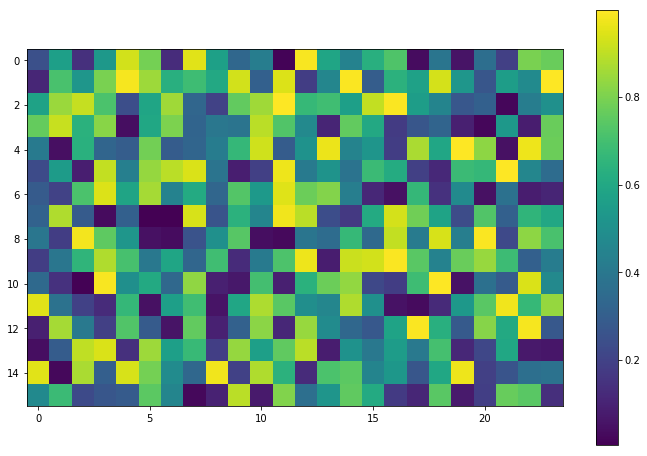

In [11]:
#Size of our test
test_size = (16, 24) #they are divisible by 32 and 8
#n was 50, 64*128 becomes unmanageable! Make tests with something lighter
#Matrix or cartesian data, never fall to the temptation nx = ny!, try to be general!

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize = (12, 8))
plt.imshow(a)
plt.colorbar()
fig.show()

In [12]:
print(a.shape)

(16, 24)


In [13]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [14]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [25]:
#Create new variables
#a.shape = [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0]) #Now domain size is [x, y]
block_size = (8,4,1) #These need to be [x, y, z]
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1) #// integer division

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (24, 16)
Block size is (8, 4, 1)
Grid size is (3, 4, 1)


In [30]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size) #CUDA wants a 32bit integer, don't pass a float!

#Copy data from device to host
c_g.get(c)

array([[0.82303643, 1.1644394 , 0.64191484, 1.3632407 , 1.3827493 ,
        1.299424  , 0.32575148, 1.116462  , 0.93451416, 0.5720333 ,
        0.65261245, 0.13655187, 1.4077882 , 1.5647453 , 0.457432  ,
        1.2468772 , 1.4940317 , 0.66600436, 1.3710127 , 0.7336818 ,
        1.3572565 , 0.5849962 , 0.8705278 , 1.1656828 ],
       [0.43478307, 1.4200935 , 1.3790247 , 1.2801268 , 1.757007  ,
        1.1083417 , 0.8305098 , 1.2841966 , 1.4383986 , 1.9243991 ,
        0.7261697 , 1.0930945 , 0.18918376, 0.69906265, 1.1807601 ,
        0.4713636 , 0.823941  , 1.5586809 , 1.1240001 , 1.3347719 ,
        0.37909743, 1.2781377 , 0.95431834, 1.10866   ],
       [1.4780734 , 1.4636917 , 1.5845621 , 1.4919009 , 0.36154997,
        1.5674884 , 1.7701647 , 0.62554693, 0.35867596, 0.9609387 ,
        1.2111782 , 1.7514596 , 1.379879  , 1.6876881 , 0.9991418 ,
        1.5460217 , 1.8643281 , 0.9478951 , 0.82816744, 0.38785556,
        0.6386514 , 0.14636256, 0.7746186 , 0.8919697 ],
       [1.253

In [31]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.82303643 1.1644394  0.64191484 1.3632407  1.3827493  1.299424
  0.32575148 1.116462   0.93451416 0.5720333  0.65261245 0.13655187
  1.4077882  1.5647453  0.457432   1.2468772  1.4940317  0.66600436
  1.3710127  0.7336818  1.3572565  0.5849962  0.8705278  1.1656828 ]
 [0.43478307 1.4200935  1.3790247  1.2801268  1.757007   1.1083417
  0.8305098  1.2841966  1.4383986  1.9243991  0.7261697  1.0930945
  0.18918376 0.69906265 1.1807601  0.4713636  0.823941   1.5586809
  1.1240001  1.3347719  0.37909743 1.2781377  0.95431834 1.10866   ]
 [1.4780734  1.4636917  1.5845621  1.4919009  0.36154997 1.5674884
  1.7701647  0.62554693 0.35867596 0.9609387  1.2111782  1.7514596
  1.379879   1.6876881  0.9991418  1.5460217  1.8643281  0.9478951
  0.82816744 0.38785556 0.6386514  0.14636256 0.7746186  0.8919697 ]
 [1.2530255  1.0707736  0.93129575 1.3361328  1.0173181  1.3182977
  1.7295592  1.2017765  1.0514582  0.74942774 1.5144746  1.6202359
  0.47256908 1.0790374  1.2333335  1.3959615  1.

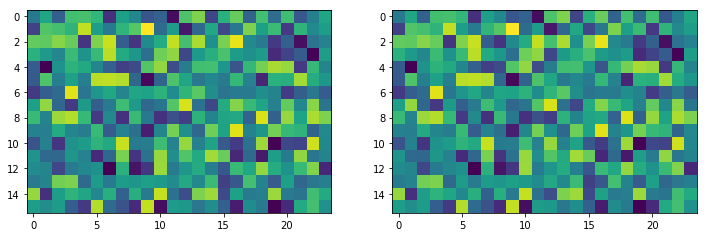

In [32]:
plt.figure(figsize=(12,8))
#plt.plot(c, '+r')
#plt.plot(c_ref, 'xb')
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)